# Galaxy cluster weak gravitational lensing analysis

<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px" alt="Rubin Observatory logo, a graphical representation of turning stars into data.">
<br>
Contact author(s): Shenming Fu <br>
Last verified to run: 2025-03-xx <br>
LSST Science Pipelines version: Weekly 2024_50 <br>
Container Size: medium <br>
Targeted learning level: beginner <br>

In [11]:
%load_ext pycodestyle_magic
%flake8_on
import logging
logging.getLogger("flake8").setLevel(logging.FATAL)

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


**Description:** This notebook demonstrates how to query Data Preview 0 (DP0) data for galaxy cluster weak gravitational lensing analysis.

**Skills:** Select background galaxies by color and make a mean shape profile.

**LSST Data Products:** Images (`deepCoadd`) and catalogs (`Object` table).

**Packages:** lsst.daf.butler, lsst.rsp

**Credit:** This tutorial was originally developed by Shenming Fu.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0.lsst.io">dp0.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

Galaxy clusters are the largest gravitionally bound objects in the Universe. According to the General Relatively, massive objects warp the spacetime, and light follows the curvature of spacetime. Thus, massive objects act like lenses that bend the path of the light emitted from distance sources. This effect is called "gravitional lensing". 

The large mass of a galaxy cluster distorts the images of backgroud galaxies  coherently, and this distortion happens over a large sky area around the cluster. The lensing effect on the shape of a single background galaxy far from the cluster center is small, but the lensing signal be detected by the average shape of many galaxies, and the reason is that the original galaxy shapes should be random. This effect is called weak gravitational lensing (WL), which shows up in the statistics of a large sample of galaxy shapes. More detailed introduction to cluster WL can be found in review papers such as [Bartelmann & Schneider (2001)](https://ui.adsabs.harvard.edu/abs/2001PhR...340..291B/abstract) and [Umetsu (2020)](https://ui.adsabs.harvard.edu/abs/2020A%26ARv..28....7U/abstract). 

Note that WL also happens between galaxies and when the light passes through the large-scale structure of the Universe (cosmic shear). Compared to galaxy-galaxy lensing and cosmic shear, the cluster WL signal is generally about 1 magnitude higher (at the level of 10 times). 

This notebook gives an example of detecting lensing signal of clusters using DP0 data.

### 1.1. Import packages
Import general packages, the LSST Science Pipelines packages for bulter and display, and Rubin Science Platform TAP package. 

In [12]:
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

import numpy as np
from scipy.stats import binned_statistic, bootstrap
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord

# LSST Science Pipelines (Stack) packages
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

from lsst.rsp import get_tap_service

## 2. Get the coadd object catalog around a cluster
There is a known cluster at (55.749deg, -32.273deg) for Right Ascension (RA), DEClination (DEC). Make a cone search for primary objects with radius 15 arcmin using Table Access Protocol (TAP). 
More details about the TAP service can be found in the tutorial Notebook for TAP. 

Select galaxies by extendedness, which is the difference between the Point Spread Function (PSF) photometry and the Composite-Model (CModel) photometry ([Abazajian et al. 2004](https://ui.adsabs.harvard.edu/abs/2004AJ....128..502A/abstract), [Bosch et al. 2018](https://ui.adsabs.harvard.edu/abs/2018PASJ...70S...5B/abstract)). CModel measures extended objects and is used for galaxy photometry generally. 

Use the `g` and `r` band color information to remove foreground galaxies, applying relevant flag cuts. Additionally, use the `r` band for shape analysis. Using the `r` band shapes is common in weak lensing studies; the main reason is the balance between seeing and sky brightness for shape measurement ([Fu et al. 2022](https://ui.adsabs.harvard.edu/abs/2022ApJ...933...84F)). Another reason is that Differential Chromatic Refraction (DCR) is weaker in redder bands, so that the PSF is less elongated along the zenith and the galaxy's pre-PSF shape is easier to measure ([Plazas et al. 2012](https://ui.adsabs.harvard.edu/abs/2012PASP..124.1113P/abstract)). 
Also, apply quality cuts to the shape measurements of galaxies for WL analysis ([Mandelbaumet al. 2018](https://ui.adsabs.harvard.edu/abs/2018PASJ...70S..25M/abstract)). 

For simplicity, skip the use of photometric redshift (photo-z) in this notebook -- the photo-z information can help select background galaxies by redshift, but background galaxies can be selected by color directly. 


In [13]:
service = get_tap_service("tap")
assert service is not None

In [14]:
center_ra = 55.749
center_dec = -32.273
radius = 15/60.

str_center_coords = str(center_ra) + ", " + str(center_dec)
str_radius = str(radius)

query = "SELECT r_ra, r_decl, "\
        "r_cModelFlux, r_cModelFluxErr, g_cModelFlux, g_cModelFluxErr, "\
        "r_hsmShapeRegauss_e1, r_hsmShapeRegauss_e2, x, y "\
        "FROM dp02_dc2_catalogs.Object "\
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "\
        "CIRCLE('ICRS', " + str_center_coords + ", " + str_radius + ")) = 1 "\
        "AND detect_isPrimary = 1 "\
        "AND r_extendedness = 1 "\
        "AND r_extendedness_flag = 0 "\
        "AND r_cModel_flag = 0 "\
        "AND g_cModel_flag = 0 "\
        "AND r_psfFlux_flag = 0 "\
        "AND r_centroid_flag = 0 "\
        "AND r_hsmShapeRegauss_sigma < 0.4 "\
        "AND r_blendedness < 0.42 "


print(query)

SELECT r_ra, r_decl, r_cModelFlux, r_cModelFluxErr, g_cModelFlux, g_cModelFluxErr, r_hsmShapeRegauss_e1, r_hsmShapeRegauss_e2, x, y FROM dp02_dc2_catalogs.Object WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), CIRCLE('ICRS', 55.749, -32.273, 0.25)) = 1 AND detect_isPrimary = 1 AND r_extendedness = 1 AND r_extendedness_flag = 0 AND r_cModel_flag = 0 AND g_cModel_flag = 0 AND r_psfFlux_flag = 0 AND r_centroid_flag = 0 AND r_hsmShapeRegauss_sigma < 0.4 AND r_blendedness < 0.42 


Run the job.

In [20]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)
assert job.phase == 'COMPLETED'

Job phase is COMPLETED


Finally, save the results into an astropy table.

In [21]:
data = job.fetch_result().to_table()
job.delete()

Delete the variable.

In [22]:
del query

Apply some further cuts on the g and r-band photometry to ensure the quality. First require the flux error to be positive to remove unphysical measurements.

In [23]:
data = data[data['r_cModelFluxErr'] > 0]
data = data[data['g_cModelFluxErr'] > 0]

Make selection based on signal-to-noise ratio (SNR). Make a typical 5-sigma cut on SNR to select well-detected objects.

In [24]:
r_SNR = data['r_cModelFlux'] / data['r_cModelFluxErr']
g_SNR = data['g_cModelFlux'] / data['g_cModelFluxErr']

sel = r_SNR > 5.
sel &= g_SNR > 5.

WL distorts galaxy shapes, and the galaxy shape is described by ellipticity. The ellipticity is constructed from the second moments of the object's 2D flux distribution with the correction of the PSF effects. 
The HSM shape is available in the catalog. The details of HSM are described in the work of [Hirata and Seljak (2003)](https://ui.adsabs.harvard.edu/abs/2003MNRAS.343..459H/abstract) and [Mandelbaum et al. (2005)](https://ui.adsabs.harvard.edu/abs/2005MNRAS.361.1287M/abstract). 

Require the measured ellipticity to be within 2; this removes galaxies with very large measured ellipticities that are unphysical, but allows galaxies with measured ellipticities slightly larger than 1 because of noise ([Mandelbaum et al. 2018](https://ui.adsabs.harvard.edu/abs/2018PASJ...70S..25M/abstract)). 

For HSM shapes, the mean ellipticity divided by 2 approximates the lensing shear. There is a small factor  turns the measured shear to the true shear, and the difference is caused by galaxy shape dispersion, measurement noise, pixelization, etc. Usually, a shear calibration corrects for this. However, accurately determining shear calibration parameters requires further image simulations, which is beyond the scope of this notebook. Thus, for demonstration, skip shear calibration but just study the mean galaxy shape in this notebook.

In [25]:
e1 = data['r_hsmShapeRegauss_e1']
e2 = data['r_hsmShapeRegauss_e2']
sel &= (e1**2 + e2**2)**0.5 < 2.
print("Fraction of large ellipticity: ", np.sum(~sel)/len(data))

Fraction of large ellipticity:  0.04576001108493834


Make the selection. 

In [26]:
data_s = data[sel]

## 3. Select galaxies by color

Create the g-r vs r color-magnitude diagram (CMD) of galaxies. Clusters generally have a typical red sequence (RS) in CMD due to evolution -- those red galaxies are the oldest and reddest in the cluster ([Kodama and Arimoto 1997](https://ui.adsabs.harvard.edu/abs/1997A%26A...320...41K/abstract); [Gladders and Yee 2000](https://ui.adsabs.harvard.edu/abs/2000AJ....120.2148G/abstract)). Galaxies that are redder than RS are background galaxies. Thus, use colors to select a sample of background galaxies, and a sample of bright cluster member galaxies -- they show different colors in CMD. Here is also an example tutorial of using the Rubin Science Platform (RSP) Portal to study RS ([Exploring Extended Object Populations with Histograms](https://dp0-2.lsst.io/tutorials-examples/portal-4.html)).

First, convert flux into magnitude and compute the magnitude uncertainty, based on the tutorial notebook DP02_01 (Introduction to Jupyter Notebooks for Data Preview 0.2). Note, the derivation of the magnitude uncertainty comes from the difference of the magnitude equation. Because m = -2.5 * log(F) + m0, where m0 is the magnitude zero, m is the magnitude, and F is the flux. Then dm = -2.5/ln(10) * dF / F, and the SNR is F / dF. 

In [7]:
r_cModel = -2.5*np.log10(data_s['r_cModelFlux']) + 31.4
g_cModel = -2.5*np.log10(data_s['g_cModelFlux']) + 31.4

fac = 2.5 / np.log(10)
r_cModel_err = fac / r_SNR[sel]

Make CMD. 

There is a concentration of galaxies at g-r~1.1, when the galaxies have different brightness (r-band magnitude). That is RS. Select galaxies redder than that, and allow some gap from the RS to avoid magnitude measurement error. 

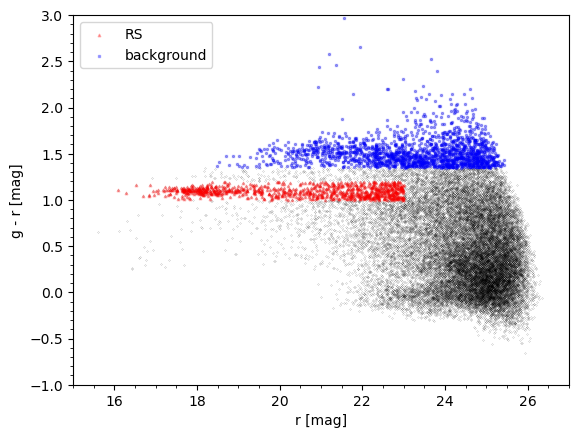

In [31]:
plt.scatter(r_cModel,
            g_cModel - r_cModel,
            s=0.03, c='k', marker='.')

sel_rs = g_cModel - r_cModel > 1.0
sel_rs &= g_cModel - r_cModel < 1.2
sel_rs &= r_cModel < 23.

plt.scatter(r_cModel[sel_rs],
            (g_cModel - r_cModel)[sel_rs],
            s=3, c='r', alpha=0.3,
            label='RS', marker='^')

sel_bg = g_cModel - r_cModel > 1.35

plt.scatter(r_cModel[sel_bg],
            (g_cModel - r_cModel)[sel_bg],
            s=3, c='b', alpha=0.3,
            label='background', marker='s')

plt.legend()

plt.xlim(15, 27)
plt.ylim(-1, 3.)
plt.xlabel('r [mag]')
plt.ylabel('g - r [mag]')
plt.minorticks_on()
plt.savefig('RS.png')

> Figure 1: Color-magnitude of galaxies with markers showing the selected background galaxies and the bright red sequence galaxies. 

Check the relation between the r-band magnitude and uncertainty, and compare that with SNR. In the figure, the uncertainty grows as the magnitude increases (i.e., the objects are fainter), which is expected.

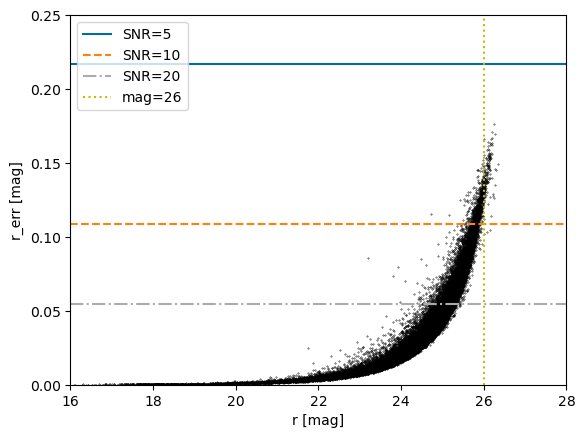

In [32]:
plt.figure()

plt.scatter(r_cModel,
            r_cModel_err,
            s=0.1, c='k')

ls_list = ['-', '--', '-.']
for i, SNR in enumerate([5, 10, 20]):
    plt.axhline(fac / SNR, c='C%d'%i, label='SNR=%d'%SNR, ls=ls_list[i])

plt.xlim(16, 28)
plt.ylim(0, 0.25)

plt.axvline(26, c='y', ls=':', label='mag=26')

plt.xlabel('r [mag]')
plt.ylabel('r_err [mag]')

plt.legend()

> Figure 2: r-band magnitude and uncertainty of galaxies.

Now, check the distribution of galaxies on the sky. Clearly, the RS galaxies have a concentration near the cluster center, but the background ones are uniformally distributed. 

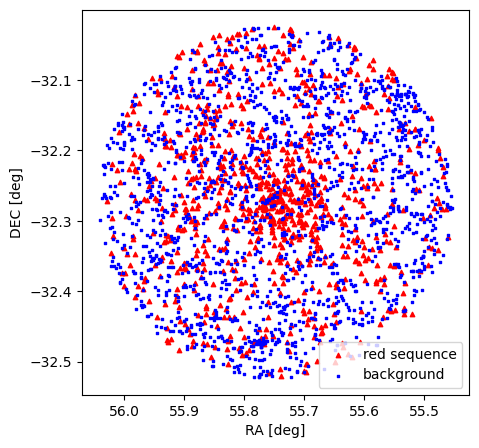

In [39]:
ra = data_s['r_ra']
dec = data_s['r_decl']

plt.figure(figsize=(5, 5))
plt.scatter(ra[sel_rs], dec[sel_rs], s=10, c='r',
            label="red sequence", marker='^')
plt.scatter(ra[sel_bg], dec[sel_bg], s=3, c='b',
            label="background", marker='s')
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')
plt.gca().invert_xaxis()
plt.legend()

plt.savefig('RS_sel.png')

> Figure 3: Sky distribution of the selected background and RS galaxies.

Also check the coadd image and see how the RS galaxies look like -- those bright large cluster galaxies do get selected. The image information comes from the tutorial notebook DP02_04a (Introduction to the Butler).

In [34]:
config = 'dp02'
collections = '2.2i/runs/DP0.2'
butler = dafButler.Butler(config, collections=collections)

datasetType = 'deepCoadd'
dataId = {'tract': 4431, 'patch': 17, 'band': 'r'}
coadd = butler.get(datasetType, dataId=dataId)

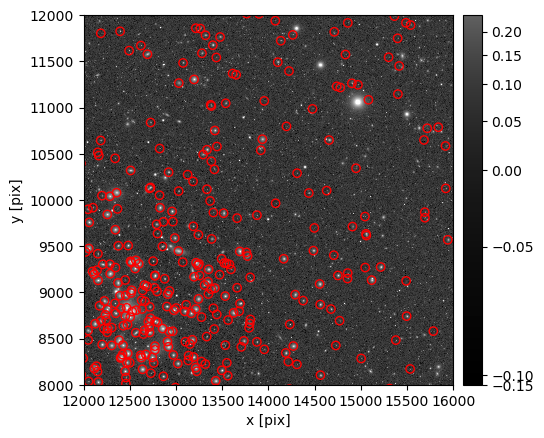

In [40]:
x = data_s['x']
y = data_s['y']
fig = plt.figure()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(coadd.image)
plt.scatter(x[sel_rs], y[sel_rs], ec='r', fc='none')
plt.xlim(12000, 16000)
plt.ylim(8000, 12000)
plt.xlabel('x [pix]')
plt.ylabel('y [pix]')
plt.savefig('RS_sel.png')


> Figure 4: Coadd r-band image with the selected RS galaxies.

In [41]:
del coadd

## 4. Lensing analysis

Compute the tangential and cross ellipticities of background galaxies toward the cluster center. Here, the tangential direction is perpendicular to the line connect the galaxy and the cluster center, and the cross direction is 45 degrees counter-clockwise 

Also, compute the radial distance in arcmin. 

In [14]:
e1 = data_s['r_hsmShapeRegauss_e1']
e2 = data_s['r_hsmShapeRegauss_e2']

coord0 = SkyCoord(center_ra, center_dec, frame='icrs', unit='deg')
coord1 = SkyCoord(ra, dec, frame='icrs', unit='deg')

position_angle = coord0.position_angle(coord1).rad + np.pi/2.

e_t = - e1 * np.cos(2.*position_angle) - e2 * np.sin(2.*position_angle)
e_x = + e1 * np.sin(2.*position_angle) - e2 * np.cos(2.*position_angle)

r = coord0.separation(coord1).arcmin

Check the distributions of the tangential ellipticities and the cross ellipticities. They show Gaussian-like distributions, but the tangential one has a mean above zero (weakly), while the cross one has a mean close to zero.

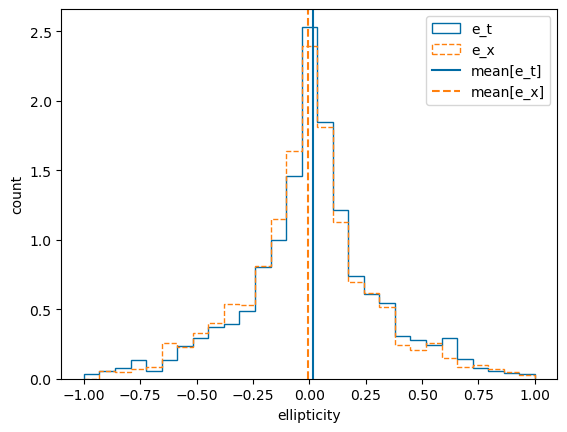

In [15]:
bins = np.linspace(-1, 1, 30)
mid = 0.5 * (bins[1:] + bins[:-1])

plt.figure()

n_e_t, _, im = plt.hist(e_t[sel_bg], bins=bins, histtype='step',
                        density=True, label='e_t')
n_e_x, _, im = plt.hist(e_x[sel_bg], bins=bins, histtype='step',
                        density=True, ls='--', label='e_x')

plt.axvline(np.mean(e_t[sel_bg]), c='C0', label='mean[e_t]')
plt.axvline(np.mean(e_x[sel_bg]), c='C1', ls='--', label='mean[e_x]')

plt.xlabel('ellipticity')
plt.ylabel('count')

plt.legend()

> Figure 5: Distributions of the tangential ellipticities and the cross ellipticities of the selected background galaxies.

The difference between two distributions shows a dipole feature as expected. 

Text(0, 0.5, 'count difference')

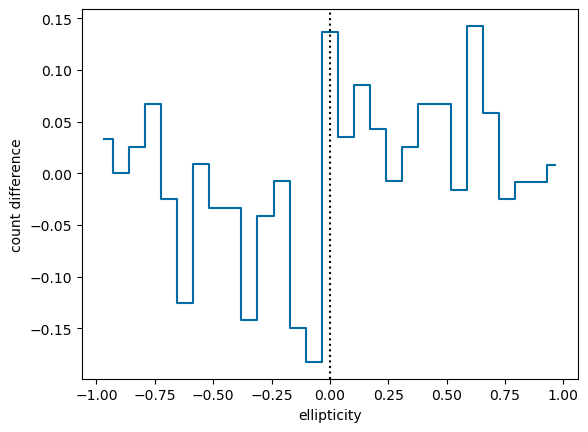

In [16]:
plt.figure()
plt.step(mid, n_e_t - n_e_x, where='mid')
plt.axvline(0, c='k', ls=':')
plt.xlabel('ellipticity')
plt.ylabel('count difference')

> Figure 6: Difference between the distributions of the tangential ellipticities and the cross ellipticities.

Bin the data by radial distance to find the mean. Estimate the error bar by std/sqrt(N). 
When plotting the cross component result, shift the data point slightly for visualization.

14.999815490020579


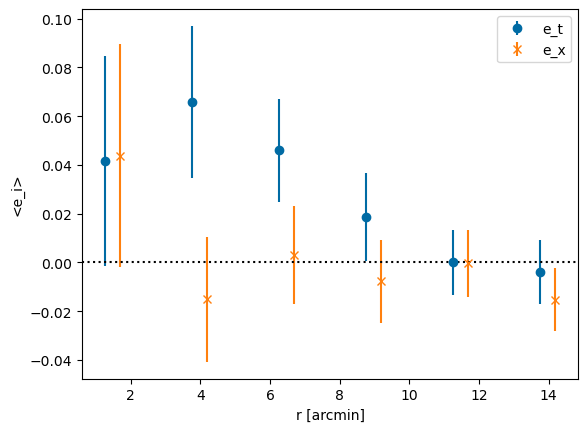

In [17]:
r_max = np.max(r)
print(r_max)

bins = np.linspace(0, r_max, 7)
mid = 0.5 * (bins[1:] + bins[:-1])

e_t_mean, _, _ = binned_statistic(r[sel_bg], e_t[sel_bg], bins=bins)
e_x_mean, _, _ = binned_statistic(r[sel_bg], e_x[sel_bg], bins=bins)

e_t_std, _, _ = binned_statistic(r[sel_bg], e_t[sel_bg], bins=bins,
                                 statistic='std')
e_x_std, _, _ = binned_statistic(r[sel_bg], e_x[sel_bg], bins=bins,
                                 statistic='std')

count, _, _ = binned_statistic(r[sel_bg], e_t[sel_bg], bins=bins,
                               statistic='count')

e_t_err = e_t_std / count ** 0.5
e_x_err = e_x_std / count ** 0.5

plt.figure()
plt.errorbar(mid, e_t_mean, e_t_err, fmt='o', label='e_t')
plt.errorbar(mid+r_max*0.03, e_x_mean, e_x_err, fmt='x', label='e_x')
plt.axhline(0, c='k', ls=':')
plt.xlabel('r [arcmin]')
plt.ylabel('<e_i>')

plt.legend()

> Figure 7: Mean shape profile with error bars estimated by statistical uncertainty.

Also use bootstrapping to estimate the error bar. Very close result to the previous one.

In [18]:
def get_stat(data, statistic=np.mean, confidence_level=0.682):
    rng = np.random.default_rng()
    res = bootstrap((data,),
                    statistic=statistic,
                    confidence_level=confidence_level,
                    random_state=rng)
    stat = np.mean(data)
    lerr = stat - res.confidence_interval[0]
    herr = res.confidence_interval[1] - stat
    return stat, lerr, herr, res.standard_error

In [19]:
inds = np.digitize(r[sel_bg], bins)

e_t_mean_list = []
e_t_lerr_list = []
e_t_herr_list = []
e_t_std_list = []

e_x_mean_list = []
e_x_lerr_list = []
e_x_herr_list = []
e_x_std_list = []

for i in range(1, len(bins)):
    sel = inds == i
    mean, lerr, herr, std = get_stat(np.ma.getdata(e_t[sel_bg][sel]))
    e_t_mean_list.append(mean)
    e_t_lerr_list.append(lerr)
    e_t_herr_list.append(herr)
    e_t_std_list.append(std)

    mean, lerr, herr, std = get_stat(np.ma.getdata(e_x[sel_bg][sel]))
    e_x_mean_list.append(mean)
    e_x_lerr_list.append(lerr)
    e_x_herr_list.append(herr)
    e_x_std_list.append(std)


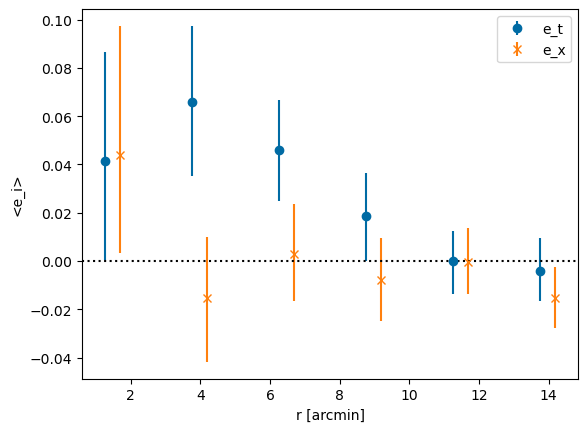

In [20]:
plt.figure()
plt.errorbar(mid, e_t_mean_list, [e_t_lerr_list, e_t_herr_list],
             fmt='o', label='e_t')
plt.errorbar(mid+r_max*0.03, e_x_mean_list, [e_x_lerr_list, e_x_herr_list],
             fmt='x', label='e_x')
plt.axhline(0, c='k', ls=':')
plt.xlabel('r [arcmin]')
plt.ylabel('<e_i>')
plt.legend()

> Figure 8: Mean shape profile with error bars estimated by bootstrapping.

##  5. Exercises for the learner
1. Use a big cutout (notebook 03c) to get the coadd image.
2. Test the shape distribution of cluster member galaxies.
3. Test other clusters.